In [1]:
import pandas as pd
import os
import numpy as np
folder_path = "Data"  # Make sure the folder path is correct

# Read each CSV file into a DataFrame
df_price = pd.read_csv(os.path.join(folder_path, "Prices.csv"))
df_chargesvar = pd.read_csv(os.path.join(folder_path, "Charges_var.csv"))
df_prod = pd.read_csv(os.path.join(folder_path, "Production.csv"))
df_plantation = pd.read_csv(os.path.join(folder_path, "plantation.csv"))
df_month_index = pd.read_csv(os.path.join(folder_path, "month_index.csv"))
df_sim=pd.read_csv(os.path.join(folder_path, "Simulation.csv"))
# Now you can work with these DataFrames as needed
df_price = df_price.fillna(0)
df_prod=df_prod.fillna(0)
serre_sau_dict = df_sim.set_index('serre')['SAU(ha)'].to_dict()


In [2]:
sum_last_37 = df_prod.iloc[:, -37:].sum(axis=1)

# Create a dictionary to associate scenario with the sum of the last 37 columns
scenario_prod = dict(zip(df_prod['Scénario'], sum_last_37))


In [3]:
scenario_variety_mapping = df_prod[['Scénario', 'variété 23-24']]

# Initialize an empty dictionary to store the mappings
variety_scenario_dict = {}

# Iterate through each row of the DataFrame
for index, row in scenario_variety_mapping.iterrows():
    scenario = row['Scénario']
    variety = row['variété 23-24']
    
    # If the variety is not already in the dictionary, add it with an empty list
    if variety not in variety_scenario_dict:
        variety_scenario_dict[variety] = []
    
    # Append the scenario to the list of scenarios for this variety
    variety_scenario_dict[variety].append(scenario)

# Print the dictionary
variety_scenario_dict

{'YAZMIN': [1, 2, 3, 4, 5, 15],
 'Adelita': [8, 9, 10],
 'VICTORIA': [11],
 'LAURITA': [12, 13, 14],
 'Clara': [18],
 'Henrienta': [19]}

In [4]:
import pandas as pd
from datetime import datetime, timedelta
import locale
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Define the start date
start_date = datetime(2024, 1, 1)

# Function to get the month index
def get_month_index(month):
    month_dict = {
        'Janvier': 1,
        'Février': 2,
        'Mars': 3,
        'Avril': 4,
        'Mai': 5,
        'Juin': 6,
        'Juillet': 7,
        'Aout': 8,
        'Septembre': 9,
        'Octobre': 10,
        'Novembre': 11,
        'Décembre': 12
    }
    return month_dict[month]

# Generate the data
data = []
months = [
    'Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre'
]

num_weeks=84

for index in range(1,num_weeks+1):
    month_index = start_date.month
    month_name = months[month_index - 1]  # Adjust for zero-based indexing

# Capitalize the first letter of the month name
    month = month_name.capitalize()

    # month = start_date.strftime('%B').capitalize()
    month_index = get_month_index(month)
    data.append([month, start_date.strftime('%d/%m/%Y'), month_index, index])
    start_date += timedelta(weeks=1)

# Create DataFrame
df_week_index = pd.DataFrame(data, columns=['Month', 'Date', 'Month Index', 'Week Index'])

# Save to CSV
month_to_week_indices = {}

# Iterate through the DataFrame to populate the dictionary
for index, row in df_week_index.iterrows():
    month = row['Month']
    week_index = row['Week Index']
    
    if month not in month_to_week_indices:
        month_to_week_indices[month] = []
    
    month_to_week_indices[month].append(week_index)

# Print the dictionary
month_to_week_indices

{'Janvier': [1, 2, 3, 4, 5, 54, 55, 56, 57],
 'Février': [6, 7, 8, 9, 58, 59, 60, 61],
 'Mars': [10, 11, 12, 13, 62, 63, 64, 65, 66],
 'Avril': [14, 15, 16, 17, 18, 67, 68, 69, 70],
 'Mai': [19, 20, 21, 22, 71, 72, 73, 74],
 'Juin': [23, 24, 25, 26, 75, 76, 77, 78, 79],
 'Juillet': [27, 28, 29, 30, 31, 80, 81, 82, 83],
 'Aout': [32, 33, 34, 35, 84],
 'Septembre': [36, 37, 38, 39, 40],
 'Octobre': [41, 42, 43, 44],
 'Novembre': [45, 46, 47, 48],
 'Décembre': [49, 50, 51, 52, 53]}

In [5]:
scenario_delai_dict = {}
scenario_duree_dict = {}
scenario_mois_dict = {}
scenario_culture={}
scenario_cmo={}
scenario_vitesse={}
scenario_cv={}
for index,row in df_chargesvar.iterrows():
    scenario = row['Scénario']
    cmo=row["Coûts de Main d'œuvre par kg de production"]
    vitesse=row["Vitesse de main d'œuvre kg/personne/jour"]
    cv=row["Coûts variable par hectar"]
    scenario_cmo[scenario]=cmo
    scenario_vitesse[scenario]=vitesse
    scenario_cv[scenario]=cv
for index, row in df_prod.iterrows():
    scenario = row['Scénario']
    delai = row['Délai pour début de production']
    duree = row['Durée de production en semaine']
    mois = row['Mois']
    culture=row['Culture']
    
    scenario_delai_dict[scenario] = delai
    scenario_duree_dict[scenario] = duree
    scenario_mois_dict[scenario] = mois
    scenario_culture[scenario] =culture
    
scenarios=list(scenario_culture.keys())


In [49]:
price={}
price["Framboise"]=np.array(df_price.iloc[0,1:])[:-1]
price["Mure"]=np.array(df_price.iloc[1,1:])[:-1]


In [50]:
secteur_serre_dict = {}

# Iterate over the rows of the DataFrame
for index, row in df_sim.iterrows():
    secteur = row['secteur']
    serre = row['serre']
    
    # If the secteur is not in the dictionary yet, create a new list
    # Otherwise, append the serre to the existing list
    if secteur not in secteur_serre_dict:
        secteur_serre_dict[int(secteur)] = [int(serre)]
    else:
        secteur_serre_dict[int(secteur)].append(int(serre))
serre_secteur_dict = {serre: secteur for secteur, serres in secteur_serre_dict.items() for serre in serres}
num_serre=df_sim.shape[0]
num_sect=len(secteur_serre_dict)


In [73]:
import numpy as np

prod_mat = np.matrix(df_prod.iloc[:, 8:])

prod = {}

def padded_dot(a, b):
    # Get the lengths of the arrays
    len_a = a.shape[1]
    len_b = b.shape[1]

    # Determine the maximum length
    max_len = max(len_a, len_b)

    # Pad arrays with zeros only to the right side
    a_padded = np.pad(a, ((0, 0), (0, max_len - len_a)), mode='constant', constant_values=0)
    b_padded = np.pad(b, ((0, 0), (0, max_len - len_b)), mode='constant', constant_values=0)

    # Perform dot product
    result = np.dot(a_padded, b_padded.T)

    return result

# Assuming month_to_week_indices, scenario_mois_dict, and scenarios are defined somewhere

for i in range(num_serre):
    for j in scenarios:

        for t in month_to_week_indices[scenario_mois_dict[j]]:
            
            if j in [8, 9, 10]:
                    price_array = np.array(price[scenario_culture[j]][t-1 + scenario_delai_dict[j] :])+5
                    prod_mat_array = np.array(prod_mat[scenarios.index(j), :])
                    prod[(i, j, t)] = serre_sau_dict[i + 1] *padded_dot(
                    price_array.reshape(1, -1),
                    prod_mat_array.reshape(1, -1)
                )
                    
            else:
                    
                    price_array = np.array(price[scenario_culture[j]][t-1 + scenario_delai_dict[j]:])
                    prod_mat_array = np.array(prod_mat[scenarios.index(j), :])
                    prod[(i, j, t)] = serre_sau_dict[i + 1] *padded_dot(
                    price_array.reshape(1, -1),
                    prod_mat_array.reshape(1, -1)
                )
                    

In [76]:
import gurobipy as gp
from gurobipy import GRB

try:
    # Create a new model
    m = gp.Model("portfolio")

    
    choices={}
    for i in range(num_serre):
        for j in scenarios:
            for t in month_to_week_indices[scenario_mois_dict[j]]:
                choices[(i,j,t)]= m.addVar(vtype=GRB.BINARY, name=f'choice_{i}_{j}_{t}')
    
   
    for i in range(num_serre):
        m.addConstr(gp.quicksum(choices[(i, j, t)] for j in scenarios for t in month_to_week_indices[scenario_mois_dict[j]]) == 1, f"constraint_{i}")
   
    # Meme scenario par secteur
    for i in range(num_sect):
        ref = secteur_serre_dict[i+1][0]
        # m.addConstr(gp.quicksum(choix_semaines[(i, t)] for t in range(90)))
        for j in secteur_serre_dict[i+1]:
            for k in scenarios:
                for t in month_to_week_indices[scenario_mois_dict[k]]:
                    m.addConstr(choices[(j-1,k,t)] 
                                == choices[(ref-1,k,t)], f'c_0_{j}_{k}_{t}')
                

    # Cette contrainte est obtenue par la contraposé de la cinquième contrainte
    for i in range(21):
        for t in month_to_week_indices[scenario_mois_dict[5]]:
            m.addConstr(choices[(i,5,t)]==0)

    #Contrainte limite de main d'oeuvre
    
    #contrainte choix
    for i in range(num_serre):
        if i!=19 and i!=20:
            for j in variety_scenario_dict["Clara"]:
                for t in month_to_week_indices[scenario_mois_dict[j]]:
                    m.addConstr(choices[(i,j,t)]==0)
            for j in variety_scenario_dict["LAURITA"]:
                for t in month_to_week_indices[scenario_mois_dict[j]]:
                    m.addConstr(choices[(i,j,t)]==0)
        else:
            if serre_sau_dict[i+1]>2.87:
                for j in variety_scenario_dict["Clara"]:
                    for t in month_to_week_indices[scenario_mois_dict[j]]:
                        m.addConstr(choices[(i,j,t)]==0)
                for j in variety_scenario_dict["LAURITA"]:
                    for t in month_to_week_indices[scenario_mois_dict[j]]:
                        m.addConstr(choices[(i,j,t)]==0)
           

    for s in range(1,91):
        scenarios_time_dict={}
        for j in scenarios:
            scenarios_time_dict[j]=[]
            if j in [4,5,20]:
                for t in month_to_week_indices[scenario_mois_dict[j]]:
                    if t+scenario_delai_dict[j]<s and s<t+scenario_delai_dict[j]+38:
                        scenarios_time_dict[j].append(t)
                    else: 
                        pass

            else:

                for t in month_to_week_indices[scenario_mois_dict[j]]:
                    if t+scenario_delai_dict[j]<s and s<t+scenario_delai_dict[j]+scenario_duree_dict[j]+1:
                        scenarios_time_dict[j].append(t)
                    else: 
                        pass
        m.addConstr(gp.quicksum(choices[(i,k,t)]*(serre_sau_dict[i+1]/scenario_vitesse[k])
            *prod_mat[scenarios.index(k),s-t-scenario_delai_dict[k]-1]
            for k in scenarios 
            for t in scenarios_time_dict[k] if scenarios_time_dict[k]!=[]
            
                for i in range(num_serre)) <= 7*600, f'mo_{s}')





    CA_expr = gp.quicksum( choices[(i,j,t)]* 
                          prod[(i, j, t)] 
                           for i in range(num_serre)
                     for j in scenarios for t in month_to_week_indices[scenario_mois_dict[j]]
                        )
    CMO_expr = gp.quicksum(choices[(i,j,t)] * scenario_prod[j]
                        #    can be changed 
                           * serre_sau_dict[i+1] * scenario_cmo[j] 
                       for j in scenarios for t in month_to_week_indices[scenario_mois_dict[j]]
                        for i in range(num_serre))
    CV_expr = gp.quicksum(choices[(i,j,t)]* 
                          serre_sau_dict[i+1] * 
                          scenario_cv[j] for j in scenarios for t in month_to_week_indices[scenario_mois_dict[j]]
                        for i in range(num_serre))

    # Set objective
    m.update()
    m.setObjective(CA_expr - CV_expr- CMO_expr, GRB.MAXIMIZE)

    # Optimize model
    m.optimize()

    # for v in m.getVars():
    #     print(f"{v.VarName} {v.X:g}")
    # After the optimization is done, you can print the expressions
    print("Value of CA_expr:", CA_expr.getValue())
    print("Value of CMO_expr:", CMO_expr.getValue())
    print("Value of CV_expr:", CV_expr.getValue())


    print(f"Obj: {m.ObjVal:g}")
    


except gp.GurobiError as e:
    print(f"Error code {e.errno}: {e}")

except AttributeError:
    print("Encountered an attribute error")


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2935 rows, 2280 columns and 27889 nonzeros
Model fingerprint: 0x64c52bff
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.06s
Presolved: 40 rows, 275 columns, 3983 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.273422e+07, 108 iterations, 0.03 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 

In [77]:
selected_vars=[]
if m.status == GRB.Status.OPTIMAL:
        # Get selected variables with value == 1
        selected_vars = [v for v in m.getVars() if v.x == 1]

        # Add selected variables to the list
        
for v in selected_vars:
        print(v.varName)

choice_0_11_45
choice_1_11_45
choice_2_11_45
choice_3_11_45
choice_4_11_45
choice_5_11_45
choice_6_4_19
choice_7_4_19
choice_8_4_19
choice_9_4_19
choice_10_4_19
choice_11_11_48
choice_12_11_48
choice_13_11_48
choice_14_11_48
choice_15_11_48
choice_16_11_48
choice_17_4_19
choice_18_4_19
choice_19_18_41
choice_20_18_41
choice_21_5_14
choice_22_5_14
choice_23_5_14


<h1>Top K<h1>

In [81]:
table_data = []
num_iterations=10
from tqdm import tqdm
# Loop for 'n' iterations
for _ in tqdm(range(num_iterations)):
    # Optimize the model
    m.optimize()

    # Retrieve and store chosen variable names
    chosen_variables = [(i, j, t) for i in range(num_serre) for j in scenarios for t in month_to_week_indices[scenario_mois_dict[j]]
                        if choices[(i, j, t)].x == 1]

    # Calculate additional values
    CA_value = CA_expr.getValue()
    CMO_value = CMO_expr.getValue()
    CV_value = CV_expr.getValue()

    # Store the data in the table
    for var in chosen_variables:
        i, j, t = var
        table_data.append({'Rank': _ + 1, 'Num Serre': i+1, 'Scenario': j, 'Month Index': t, 
                           'CA_expr': CA_value, 'CMO_expr': CMO_value, 'CV_expr': CV_value})

    # Create a set of chosen variables indices
    

    # Add constraints to ensure the sum of chosen variables is not equal to n
    m.addConstr(gp.quicksum(choices[(i, j, t)] for i, j, t in chosen_variables) <= 23)

# Convert table_data to a DataFrame
df = pd.DataFrame(table_data)

  0%|          | 0/10 [00:00<?, ?it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2935 rows, 2280 columns and 27889 nonzeros
Model fingerprint: 0x64c52bff
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolved: 40 rows, 275 columns, 3983 nonzeros

Continuing optimization...


Cutting planes:
  Cover: 6
  Clique: 1
  MIR: 1
  StrongCG: 1

Explored 1 nodes (168 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 4 (of 4 available processors)

Solution count 6: 1.25027e+07 1.24188e+07 1.23726e+07 ... -5.93377e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 1.250270765412e+07, best bound 1.250270765412e+0

 10%|█         | 1/10 [00:00<00:02,  3.83it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2936 rows, 2280 columns and 27913 nonzeros
Model fingerprint: 0xfc3bb34f
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R2935 by 1.000000000

Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.09s
Presolved: 41 rows, 275 columns, 3989 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.2734

 20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2937 rows, 2280 columns and 27937 nonzeros
Model fingerprint: 0x2cd28a50
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R2936 by 1.000000000

Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.10s
Presolved: 42 rows, 275 columns, 3995 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.2734

 30%|███       | 3/10 [00:02<00:05,  1.30it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2938 rows, 2280 columns and 27961 nonzeros
Model fingerprint: 0xbb8aa60f
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R2937 by 1.000000000

Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.15s
Presolved: 43 rows, 275 columns, 4001 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.2734

 40%|████      | 4/10 [00:02<00:04,  1.41it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2939 rows, 2280 columns and 27985 nonzeros
Model fingerprint: 0xbc6b6206
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R2938 by 1.000000000

Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.07s
Presolved: 44 rows, 275 columns, 4007 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.2734

 50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2940 rows, 2280 columns and 28009 nonzeros
Model fingerprint: 0x9dd2399c
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R2939 by 1.000000000

Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.12s
Presolved: 45 rows, 275 columns, 4013 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.2734

 60%|██████    | 6/10 [00:03<00:02,  1.51it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2941 rows, 2280 columns and 28033 nonzeros
Model fingerprint: 0x398dc76a
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R2940 by 1.000000000

Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.06s
Presolved: 46 rows, 275 columns, 4019 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.2734

 70%|███████   | 7/10 [00:04<00:02,  1.49it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2942 rows, 2280 columns and 28057 nonzeros
Model fingerprint: 0x28cf9b7d
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R2941 by 1.000000000

Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.07s
Presolved: 47 rows, 275 columns, 4025 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.2734

 80%|████████  | 8/10 [00:05<00:01,  1.48it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2943 rows, 2280 columns and 28081 nonzeros
Model fingerprint: 0x4a0fe09a
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R2942 by 1.000000000

Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.10s
Presolved: 48 rows, 275 columns, 4031 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.2734

 90%|█████████ | 9/10 [00:06<00:00,  1.39it/s]

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2944 rows, 2280 columns and 28105 nonzeros
Model fingerprint: 0x8b5c1fa6
Variable types: 0 continuous, 2280 integer (2280 binary)
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R2943 by 1.000000000

Found heuristic solution: objective -5933765.250
Presolve removed 2895 rows and 2005 columns
Presolve time: 0.12s
Presolved: 49 rows, 275 columns, 4037 nonzeros
Found heuristic solution: objective 1.185225e+07
Variable types: 0 continuous, 275 integer (275 binary)

Root relaxation: objective 1.2734

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


In [82]:

df["Secteur"] = df["Num Serre"].apply(lambda x: serre_secteur_dict.get(x, np.nan))
df_bis=df[["Rank","Secteur", "Scenario"]]
df_bis=df_bis.drop_duplicates()
df_bis=df_bis[["Secteur", "Scenario"]]
df_bis

,Secteur,Scenario
0,1,11
6,2,4
11,3,11
17,4,4
19,5,18
21,6,5
24,1,11
30,2,4
35,3,11
41,4,4


In [83]:
import matplotlib.pyplot as plt
scenario_counts = {}
for row in df_bis.itertuples():
  sector, scenario = row.Secteur, row.Scenario
  if sector not in scenario_counts:
    scenario_counts[sector] = {}
  scenario_counts[sector][scenario] = scenario_counts[sector].get(scenario, 0) + 1

# Define colors for the bars (optional)
  # Adjust as needed for more sectors
data=scenario_counts
data


{1: {11: 7, 4: 3},
 2: {4: 7, 11: 3},
 3: {11: 10},
 4: {4: 10},
 5: {18: 6, 12: 4},
 6: {5: 10}}

In [84]:

# Extract keys and values from the dictionary
keys = list(data.keys())
values = list(data.values())

# Separate data for each inner dictionary with zeros for missing keys
inner_data = []
for value in values:
    # Get all unique keys from the entire data dictionary
    all_keys = set(key for inner_dict in data.values() for key in inner_dict.keys())
    # Create a list with zeros for missing keys and values for existing keys
    inner_data.append([value.get(key, 0) for key in all_keys])

# 
m=np.matrix(inner_data).T


In [86]:
m

matrix([[ 3,  7,  0, 10,  0,  0],
        [ 0,  0,  0,  0,  0, 10],
        [ 7,  3, 10,  0,  0,  0],
        [ 0,  0,  0,  0,  4,  0],
        [ 0,  0,  0,  0,  6,  0]])

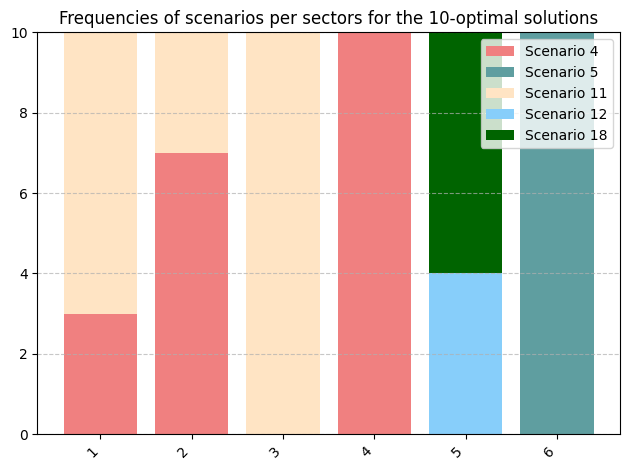

In [89]:
import matplotlib.pyplot as plt



y1=np.array(m[0,:])[0]
y2=np.array(m[1,:])[0]
y3=np.array(m[2,:])[0]
y4=np.array(m[3,:])[0]
y5=np.array(m[4,:])[0]

# plt.bar(keys, y1, color='lightcoral')
# plt.bar(keys, y2, bottom=y1, color='bisque')
# plt.bar(keys, y3, bottom=y1+y2, color='lightskyblue')
plt.bar(keys, y1, color='lightcoral')
plt.bar(keys, y2, bottom=y1, color='cadetblue')
plt.bar(keys, y3, bottom=y1+y2, color='bisque')
plt.bar(keys, y4, bottom=y1+y2+y3, color='lightskyblue')
plt.bar(keys, y5, bottom=y1+y2+y3+y4, color='darkgreen')

plt.legend(["Scenario "+str(i) for i in list(set(df_bis['Scenario'].values))])
plt.title("Frequencies of scenarios per sectors for the 10-optimal solutions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent overlapping elements

plt.show()
